# TuringBench

**Models**
- BERTurk
- BERT
- RoBERTa
- GPT-2
- XLNet
- Electra
- DistilBERT

This notebook does AI-generated Text Detection with different NLP models. In a proposed method, adversarial training is applied through these models. The aim is to enhance the original models' performances by utilizing this method through the training phase. This notebook only trains the models without Adversarial. Refer to AdversarialTraining.ipynb for those.

In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AdamW, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification


import warnings
warnings.filterwarnings('ignore')

In [2]:
# If you run the code on Google Colab
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/reviews_omitted15words.csv')
data.head()

,review,label
0,oka üniversites hastane çalışa son zaman göste...,ai
1,ekiç kaşar peynir tam bir hayal kırıklık marke...,ai
2,similaç deva süt aldık iç tah çık bebek ür tük...,ai
3,ilha duma hukuk büro sürekli borç mesaj alıyor...,ai
4,samsungu marka kamera flaş ilgil yaşadık sor i...,ai


In [4]:
# Define a custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
# Prepare the dataset for training
def is_valid_text(entry):
    return isinstance(entry, str)

# Assuming 'data' is a pandas DataFrame
valid_indices = [i for i, entry in enumerate(data['review']) if is_valid_text(entry)]
texts = [data['review'][i] for i in valid_indices]
labels = [data['label'][i] for i in valid_indices]

# Convert labels to numerical
labels = [1 if x == 'ai' else 0 for x in labels]

# Update the DataFrame with the filtered data
data = data.iloc[valid_indices].copy()  # Create a new DataFrame with the filtered rows
data['review'] = texts
data['label'] = labels


In [6]:
# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

## Models

### BERTurk

In [7]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased', num_labels=2)

# Prepare the data for BERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 110,618,882


Step,Training Loss,Validation Loss
100,0.089000,0.109810
200,0.000300,0.126077
300,0.000600,0.144163
400,0.033300,0.145762
500,0.000200,0.745659
600,0.000200,0.178953
700,0.168100,0.285789
800,0.109300,0.378615
900,0.098100,0.310393
1000,0.046900,0.143785



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/model.safetensors


TrainOutput(global_step=1160, training_loss=0.054989490813449234, metrics={'train_runtime': 211.2144, 'train_samples_per_second': 43.932, 'train_steps_per_second': 5.492, 'total_flos': 476837398962000.0, 'train_loss': 0.054989490813449234, 'epoch': 1.0})

In [13]:
# Evaluate the model
berturk_results = trainer.evaluate()
print(berturk_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.11803391575813293, 'eval_runtime': 5.4917, 'eval_samples_per_second': 422.457, 'eval_steps_per_second': 26.404, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


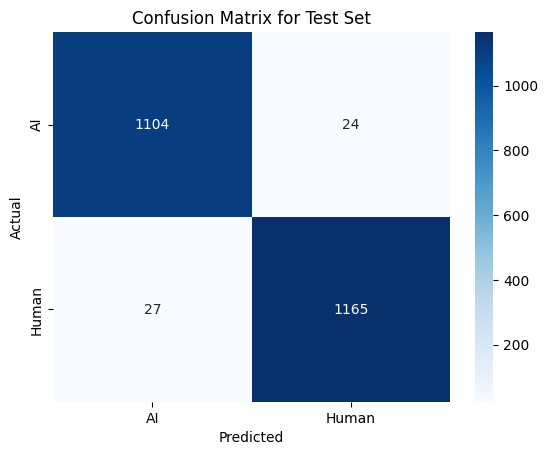

              precision    recall  f1-score   support

       Human       0.98      0.98      0.98      1128
          AI       0.98      0.98      0.98      1192

    accuracy                           0.98      2320
   macro avg       0.98      0.98      0.98      2320
weighted avg       0.98      0.98      0.98      2320



In [14]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [15]:
model_save_path = '/content/drive/MyDrive/test/berturk_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/berturk_model
Configuration saved in /content/drive/MyDrive/test/berturk_model/config.json
Model weights saved in /content/drive/MyDrive/test/berturk_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/berturk_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/berturk_model/special_tokens_map.json


('/content/drive/MyDrive/test/berturk_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/berturk_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/berturk_model/vocab.txt',
 '/content/drive/MyDrive/test/berturk_model/added_tokens.json')

### BERT

In [16]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Prepare the data for BERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.js

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mod

In [17]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 109,483,778


Step,Training Loss,Validation Loss
100,0.634000,0.594204
200,0.159000,0.573605
300,0.374800,0.778445
400,0.457900,0.385087
500,0.205700,0.284383
600,0.247400,0.279720
700,0.558100,0.193433
800,0.115000,0.214957
900,0.242700,0.158236
1000,0.336700,0.163133



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/model.safetensors


TrainOutput(global_step=1160, training_loss=0.3170020112960503, metrics={'train_runtime': 311.861, 'train_samples_per_second': 29.754, 'train_steps_per_second': 3.72, 'total_flos': 877380814090080.0, 'train_loss': 0.3170020112960503, 'epoch': 1.0})

In [18]:
# Evaluate the model
bert_results = trainer.evaluate()
print(bert_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.15285593271255493, 'eval_runtime': 10.7549, 'eval_samples_per_second': 215.715, 'eval_steps_per_second': 13.482, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


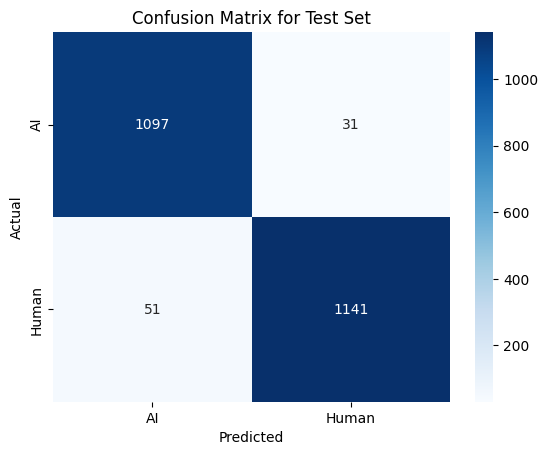

              precision    recall  f1-score   support

       Human       0.96      0.97      0.96      1128
          AI       0.97      0.96      0.97      1192

    accuracy                           0.96      2320
   macro avg       0.96      0.96      0.96      2320
weighted avg       0.96      0.96      0.96      2320



In [19]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [20]:
model_save_path = '/content/drive/MyDrive/test/bert_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/bert_model
Configuration saved in /content/drive/MyDrive/test/bert_model/config.json
Model weights saved in /content/drive/MyDrive/test/bert_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/bert_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/bert_model/special_tokens_map.json


('/content/drive/MyDrive/test/bert_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/bert_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/bert_model/vocab.txt',
 '/content/drive/MyDrive/test/bert_model/added_tokens.json')

### RoBERTa

In [ ]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.j

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/model.safetensors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkp

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',  # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs_roberta',    # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 124,647,170


Step,Training Loss,Validation Loss
100,0.364400,0.563600
200,0.390400,0.345038
300,0.164600,0.112526
400,0.151000,0.188287
500,0.242200,0.112087
600,0.043700,0.059150
700,0.112700,0.099747
800,0.031000,0.113766
900,0.055000,0.071746
1000,0.076700,0.081296



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-100
Configuration saved in ./results_roberta/checkpoint-100/config.json
Model weights saved in ./results_roberta/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-200
Configuration saved in ./results_roberta/checkpoint-200/config.json
Model weights saved in ./results_roberta/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-300
Configuration saved in ./results_roberta/checkpoint-300/config.json
Model weights saved in ./results_roberta/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-400
Configuration saved in ./results_roberta/check

TrainOutput(global_step=1160, training_loss=0.2075888352693412, metrics={'train_runtime': 458.7769, 'train_samples_per_second': 20.228, 'train_steps_per_second': 2.528, 'total_flos': 1216066408992000.0, 'train_loss': 0.2075888352693412, 'epoch': 1.0})

In [ ]:
# Evaluate the model
roberta_results = trainer.evaluate()
print(roberta_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.06435385346412659, 'eval_runtime': 16.6933, 'eval_samples_per_second': 138.978, 'eval_steps_per_second': 8.686, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


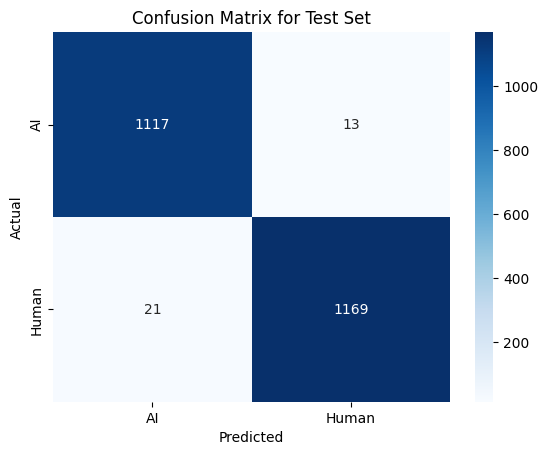

              precision    recall  f1-score   support

       Human       0.98      0.99      0.99      1130
          AI       0.99      0.98      0.99      1190

    accuracy                           0.99      2320
   macro avg       0.99      0.99      0.99      2320
weighted avg       0.99      0.99      0.99      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/roberta_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/roberta_model
Configuration saved in /content/drive/MyDrive/test/roberta_model/config.json
Model weights saved in /content/drive/MyDrive/test/roberta_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/roberta_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/roberta_model/special_tokens_map.json


('/content/drive/MyDrive/test/roberta_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/roberta_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/roberta_model/vocab.json',
 '/content/drive/MyDrive/test/roberta_model/merges.txt',
 '/content/drive/MyDrive/test/roberta_model/added_tokens.json')

### GPT-2

In [ ]:
# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)

# Prepare the data for GPT-2
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],


In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_gpt2',     # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 124,441,344


Step,Training Loss,Validation Loss
100,0.555100,0.458386
200,0.259100,0.071167
300,0.165600,0.083692
400,0.177100,0.051064
500,0.119300,0.048934
600,0.113000,0.138947
700,0.121500,0.052094
800,0.007900,0.065101
900,0.107200,0.061761
1000,0.054600,0.048144



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-100
Configuration saved in ./results_gpt2/checkpoint-100/config.json
Model weights saved in ./results_gpt2/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-200
Configuration saved in ./results_gpt2/checkpoint-200/config.json
Model weights saved in ./results_gpt2/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-300
Configuration saved in ./results_gpt2/checkpoint-300/config.json
Model weights saved in ./results_gpt2/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-400
Configuration saved in ./results_gpt2/checkpoint-400/config.json
Model weigh

TrainOutput(global_step=1160, training_loss=0.1585461779039931, metrics={'train_runtime': 464.0095, 'train_samples_per_second': 20.0, 'train_steps_per_second': 2.5, 'total_flos': 1198208911933440.0, 'train_loss': 0.1585461779039931, 'epoch': 1.0})

In [ ]:
# Evaluate the model
gpt2_results = trainer.evaluate()
print(gpt2_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.05423137918114662, 'eval_runtime': 17.2158, 'eval_samples_per_second': 134.76, 'eval_steps_per_second': 8.422, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


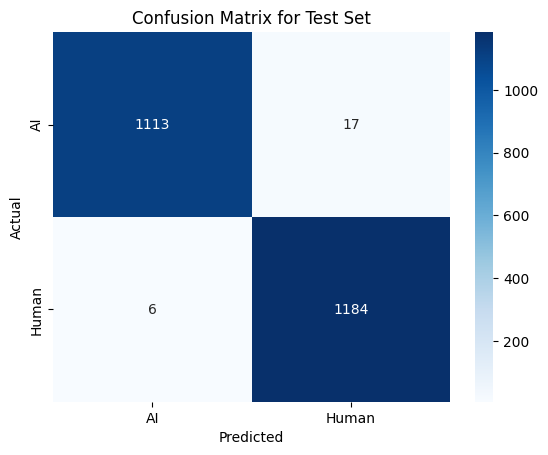

              precision    recall  f1-score   support

       Human       0.99      0.98      0.99      1130
          AI       0.99      0.99      0.99      1190

    accuracy                           0.99      2320
   macro avg       0.99      0.99      0.99      2320
weighted avg       0.99      0.99      0.99      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/gpt2_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/gpt2_model
Configuration saved in /content/drive/MyDrive/test/gpt2_model/config.json
Model weights saved in /content/drive/MyDrive/test/gpt2_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/gpt2_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/gpt2_model/special_tokens_map.json


('/content/drive/MyDrive/test/gpt2_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/gpt2_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/gpt2_model/vocab.json',
 '/content/drive/MyDrive/test/gpt2_model/merges.txt',
 '/content/drive/MyDrive/test/gpt2_model/added_tokens.json')

### XLNet

In [ ]:
# Initialize the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Prepare the data for XLNet
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/tokenizer.json


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.42.4",
  "untie_r":

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/pytorch_model.bin
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_pro

In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_xlnet',    # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs_xlnet',      # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 117,310,466


Step,Training Loss,Validation Loss
100,0.442500,0.188323
200,0.103400,0.109130
300,0.249200,0.412789
400,0.237700,0.460821
500,0.409400,0.182267
600,0.143100,0.320945
700,0.315700,0.203228
800,0.198900,0.117853
900,0.062300,0.059088
1000,0.042500,0.044660



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-100
Configuration saved in ./results_xlnet/checkpoint-100/config.json
Model weights saved in ./results_xlnet/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-200
Configuration saved in ./results_xlnet/checkpoint-200/config.json
Model weights saved in ./results_xlnet/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-300
Configuration saved in ./results_xlnet/checkpoint-300/config.json
Model weights saved in ./results_xlnet/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-400
Configuration saved in ./results_xlnet/checkpoint-400/config.json


TrainOutput(global_step=1160, training_loss=0.2608126138698245, metrics={'train_runtime': 749.5902, 'train_samples_per_second': 12.38, 'train_steps_per_second': 1.548, 'total_flos': 1440603963659520.0, 'train_loss': 0.2608126138698245, 'epoch': 1.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.04238657280802727, 'eval_runtime': 28.1517, 'eval_samples_per_second': 82.411, 'eval_steps_per_second': 5.151, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


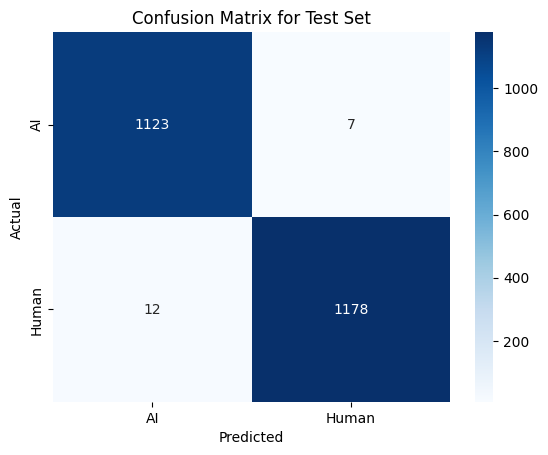

              precision    recall  f1-score   support

       Human       0.99      0.99      0.99      1130
          AI       0.99      0.99      0.99      1190

    accuracy                           0.99      2320
   macro avg       0.99      0.99      0.99      2320
weighted avg       0.99      0.99      0.99      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/xlnet_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/xlnet_model
Configuration saved in /content/drive/MyDrive/test/xlnet_model/config.json
Model weights saved in /content/drive/MyDrive/test/xlnet_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/xlnet_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/xlnet_model/special_tokens_map.json


('/content/drive/MyDrive/test/xlnet_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/xlnet_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/xlnet_model/spiece.model',
 '/content/drive/MyDrive/test/xlnet_model/added_tokens.json')

### Electra

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google--electra-small-discriminator/snapshots/fa8239aadc095e9164941d05878b98afe9b953c3/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--electra-small-discriminator/snapshots/fa8239aadc095e9164941d05878b98afe9b953c3/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--electra-small-discriminator/snapshots/fa8239aadc095e9164941d05878b98afe9b953c3/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--electra-small-discriminator/snapshots/fa8239aadc095e9164941d05878b98afe9b953c3/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-small-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs

In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_electra',    # Output directory
    num_train_epochs=1,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=16,     # Batch size for evaluation
    warmup_steps=500,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Strength of weight decay
    logging_dir='./logs_electra',      # Directory for storing logs
    logging_steps=10,                  # Log every X steps
    evaluation_strategy='steps',       # Evaluation strategy to adopt during training
    eval_steps=100,                    # Evaluation step to perform evaluation
    save_steps=100,                    # Save checkpoint every X steps
    log_level='info',                  # Set logging level to info
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 13,549,314


Step,Training Loss,Validation Loss
100,0.688300,0.682234
200,0.539000,0.569972
300,0.383800,0.411565
400,0.371000,0.273899
500,0.269300,0.237328
600,0.126200,0.245402
700,0.484800,0.193809
800,0.231000,0.403788
900,0.382300,0.241804
1000,0.319200,0.248372



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-100
Configuration saved in ./results_electra/checkpoint-100/config.json
Model weights saved in ./results_electra/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-200
Configuration saved in ./results_electra/checkpoint-200/config.json
Model weights saved in ./results_electra/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-300
Configuration saved in ./results_electra/checkpoint-300/config.json
Model weights saved in ./results_electra/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-400
Configuration saved in ./results_electra/check

TrainOutput(global_step=1160, training_loss=0.34780317729274773, metrics={'train_runtime': 74.956, 'train_samples_per_second': 123.793, 'train_steps_per_second': 15.476, 'total_flos': 98103929491296.0, 'train_loss': 0.34780317729274773, 'epoch': 1.0})

In [ ]:
# Evaluate the model
electra_results = trainer.evaluate()
print(electra_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.20589733123779297, 'eval_runtime': 1.9384, 'eval_samples_per_second': 1196.891, 'eval_steps_per_second': 74.806, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


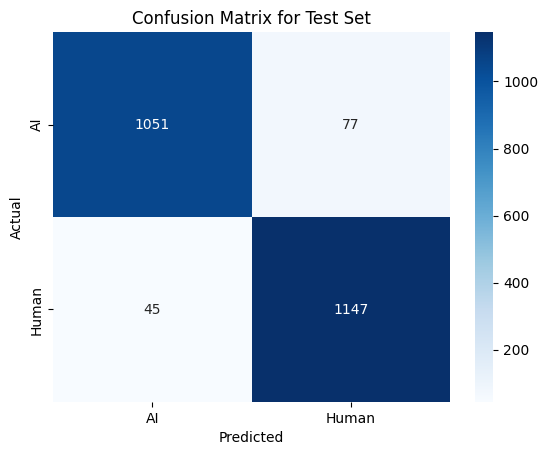

              precision    recall  f1-score   support

       Human       0.96      0.93      0.95      1128
          AI       0.94      0.96      0.95      1192

    accuracy                           0.95      2320
   macro avg       0.95      0.95      0.95      2320
weighted avg       0.95      0.95      0.95      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/electra_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/electra_model
Configuration saved in /content/drive/MyDrive/test/electra_model/config.json
Model weights saved in /content/drive/MyDrive/test/electra_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/electra_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/electra_model/special_tokens_map.json


('/content/drive/MyDrive/test/electra_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/electra_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/electra_model/vocab.txt',
 '/content/drive/MyDrive/test/electra_model/added_tokens.json')

### DistilBERT

In [ ]:
# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Prepare the data for DistilBERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',    # Output directory
    num_train_epochs=1,                   # Number of training epochs
    per_device_train_batch_size=8,        # Batch size for training
    per_device_eval_batch_size=16,        # Batch size for evaluation
    warmup_steps=500,                     # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # Strength of weight decay
    logging_dir='./logs_distilbert',      # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',          # Evaluation strategy to adopt during training
    eval_steps=100,                       # Evaluation step to perform evaluation
    save_steps=100,                       # Save checkpoint every X steps
    log_level='info',                     # Set logging level to info
    log_level_replica='info'              # Save checkpoint every X steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 66,955,010


Step,Training Loss,Validation Loss
100,0.655700,0.647249
200,0.329700,0.334919
300,0.270900,0.250023
400,0.315800,0.468763
500,0.421800,0.276630
600,0.296300,0.538621
700,0.548100,0.213734
800,0.230300,0.283780
900,0.289500,0.170784
1000,0.366400,0.151709



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-100
Configuration saved in ./results_distilbert/checkpoint-100/config.json
Model weights saved in ./results_distilbert/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-200
Configuration saved in ./results_distilbert/checkpoint-200/config.json
Model weights saved in ./results_distilbert/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-300
Configuration saved in ./results_distilbert/checkpoint-300/config.json
Model weights saved in ./results_distilbert/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-400
Configuration sa

TrainOutput(global_step=1160, training_loss=0.3244396681158707, metrics={'train_runtime': 173.9303, 'train_samples_per_second': 53.349, 'train_steps_per_second': 6.669, 'total_flos': 441731169046368.0, 'train_loss': 0.3244396681158707, 'epoch': 1.0})

In [ ]:
# Evaluate the model
d_bert_results = trainer.evaluate()
print(d_bert_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.14192485809326172, 'eval_runtime': 6.1254, 'eval_samples_per_second': 378.748, 'eval_steps_per_second': 23.672, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


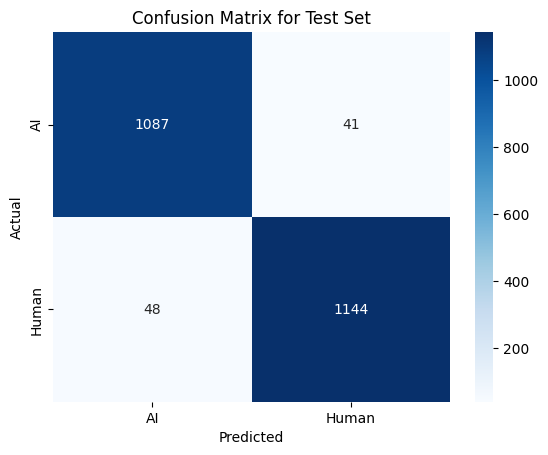

              precision    recall  f1-score   support

       Human       0.96      0.96      0.96      1128
          AI       0.97      0.96      0.96      1192

    accuracy                           0.96      2320
   macro avg       0.96      0.96      0.96      2320
weighted avg       0.96      0.96      0.96      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/d_bert_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/d_bert_model
Configuration saved in /content/drive/MyDrive/test/d_bert_model/config.json
Model weights saved in /content/drive/MyDrive/test/d_bert_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/d_bert_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/d_bert_model/special_tokens_map.json


('/content/drive/MyDrive/test/d_bert_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/d_bert_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/d_bert_model/vocab.txt',
 '/content/drive/MyDrive/test/d_bert_model/added_tokens.json')